C:\Users\natal\AppData\Local\Programs\Python\Python37\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


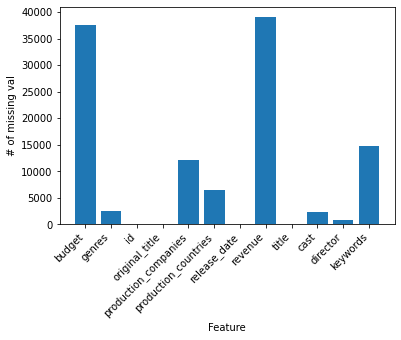

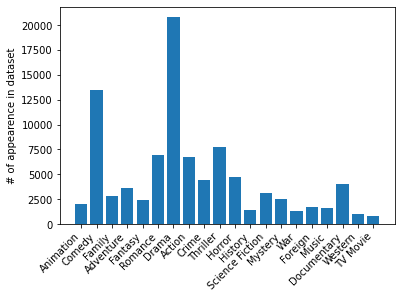

Animation :  [(878, 'Family'), (564, 'Comedy')]
Comedy :  [(4295, 'Drama'), (3197, 'Romance')]
Family :  [(1205, 'Comedy'), (878, 'Animation')]
Adventure :  [(1775, 'Action'), (1071, 'Drama')]
Fantasy :  [(744, 'Comedy'), (712, 'Drama')]
Romance :  [(4605, 'Drama'), (3197, 'Comedy')]
Drama :  [(4605, 'Romance'), (4295, 'Comedy')]
Action :  [(2395, 'Thriller'), (2368, 'Drama')]
Crime :  [(2581, 'Drama'), (2055, 'Thriller')]
Thriller :  [(3491, 'Drama'), (2395, 'Action')]
Horror :  [(1951, 'Thriller'), (890, 'Science Fiction')]
History :  [(1098, 'Drama'), (346, 'War')]
Science Fiction :  [(1101, 'Action'), (890, 'Horror')]
Mystery :  [(1535, 'Thriller'), (1201, 'Drama')]
War :  [(1006, 'Drama'), (346, 'History')]
Foreign :  [(1009, 'Drama'), (408, 'Comedy')]
Music :  [(645, 'Drama'), (578, 'Comedy')]
Documentary :  [(348, 'Music'), (216, 'Drama')]
Western :  [(371, 'Action'), (277, 'Drama')]
TV Movie :  [(406, 'Drama'), (174, 'Comedy')]


In [1]:
%run data_prep.ipynb

In [2]:
original_movies_df = movies_df.copy() # Useful to go back to the original datframe 
movies_df.head()

,budget,genres,id,original_title,production_companies,production_countries,release_date,revenue,title,cast,director,keywords
0,30000000,"[Animation, Comedy, Family]",862,Toy Story,[Pixar Animation Studios],[United States of America],1995-10-30,373554033.0,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",[John Lasseter],"[jealousy, toy, boy, friendship, friends, riva..."
1,65000000,"[Adventure, Fantasy, Family]",8844,Jumanji,"[TriStar Pictures, Teitler Film, Interscope Co...",[United States of America],1995-12-15,262797249.0,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",[Joe Johnston],"[board game, disappearance, based on children'..."
2,0,"[Romance, Comedy]",15602,Grumpier Old Men,"[Warner Bros., Lancaster Gate]",[United States of America],1995-12-22,0.0,Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",[Howard Deutch],"[fishing, best friend, duringcreditsstinger, o..."
3,16000000,"[Comedy, Drama, Romance]",31357,Waiting to Exhale,[Twentieth Century Fox Film Corporation],[United States of America],1995-12-22,81452156.0,Waiting to Exhale,"[Whitney Houston, Angela Bassett, Loretta Devi...",[Forest Whitaker],"[based on novel, interracial relationship, sin..."
4,0,[Comedy],11862,Father of the Bride Part II,"[Sandollar Productions, Touchstone Pictures]",[United States of America],1995-02-10,76578911.0,Father of the Bride Part II,"[Steve Martin, Diane Keaton, Martin Short, Kim...",[Charles Shyer],"[baby, midlife crisis, confidence, aging, daug..."


In [3]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import xgboost as xgb
import gensim.downloader
import numpy as np

In [4]:
# Replaces column col of lists of labels with a binary matrix.
# Returns new dataframe and new columns' names.
def binarize_column(df, col):
    mlb = MultiLabelBinarizer()
    return df.join(pd.DataFrame(mlb.fit_transform(df[col]), columns=mlb.classes_, index=df.index), 
                   rsuffix="_suffix").drop(col, axis=1), list(mlb.classes_)

# Takes pandas Series with lists of labels as values.
# Returns a list of labels for which number of occurances > limit.
# Number of labels for 'keywords': > 0 : 18186, > 10 : 2193, > 20 : 1158
def popular_labels(series, limit):
    counts = {}
    for l in series:
        for v in l:
            counts[v] = counts.get(v, 0)+1
    return [k for k,v in counts.items() if v > limit]

# Takes pandas Series with lists of labels as values.
# Creates a new series with only labels that occur at least 'limit' times.
def limit_labels(series, limit):
    new_series = series.copy()
    labels = popular_labels(series, limit)
    for i, l in series.iteritems():
        new_l = [val for val in l if val in labels]
        new_series[i] = new_l
    return new_series

In [5]:
# Transform categorical features into binary matrixes
movies_df['production_countries'] = limit_labels(movies_df['production_countries'], 20)
movies_df, _ = binarize_column(movies_df, 'production_countries')
movies_df['keywords'] = limit_labels(movies_df['keywords'], 20)
movies_df, _ = binarize_column(movies_df, 'keywords')

movies_df.head()

,budget,genres,id,original_title,production_companies,release_date,revenue,title,cast,director,...,yacht,yakuza,young adult,young boy,young love,youth,zatoichi,zombie,zombie apocalypse,zoo
0,30000000,"[Animation, Comedy, Family]",862,Toy Story,[Pixar Animation Studios],1995-10-30,373554033.0,Toy Story,"[Tom Hanks, Tim Allen, Don Rickles, Jim Varney...",[John Lasseter],...,0,0,0,0,0,0,0,0,0,0
1,65000000,"[Adventure, Fantasy, Family]",8844,Jumanji,"[TriStar Pictures, Teitler Film, Interscope Co...",1995-12-15,262797249.0,Jumanji,"[Robin Williams, Jonathan Hyde, Kirsten Dunst,...",[Joe Johnston],...,0,0,0,0,0,0,0,0,0,0
2,0,"[Romance, Comedy]",15602,Grumpier Old Men,"[Warner Bros., Lancaster Gate]",1995-12-22,0.0,Grumpier Old Men,"[Walter Matthau, Jack Lemmon, Ann-Margret, Sop...",[Howard Deutch],...,0,0,0,0,0,0,0,0,0,0
3,16000000,"[Comedy, Drama, Romance]",31357,Waiting to Exhale,[Twentieth Century Fox Film Corporation],1995-12-22,81452156.0,Waiting to Exhale,"[Whitney Houston, Angela Bassett, Loretta Devi...",[Forest Whitaker],...,0,0,0,0,0,0,0,0,0,0
4,0,[Comedy],11862,Father of the Bride Part II,"[Sandollar Productions, Touchstone Pictures]",1995-02-10,76578911.0,Father of the Bride Part II,"[Steve Martin, Diane Keaton, Martin Short, Kim...",[Charles Shyer],...,0,0,0,0,0,0,0,0,0,0


In [6]:
#create list of possible genres
genres = []
for x in movies_df['genres']:
    for genre in x:
        if genre not in genres:
            genres.append(genre)

In [7]:
train_df, test_df = train_test_split(movies_df, test_size=0.2)

X_cols = ['budget', 'revenue'] # For now only numeric features
X_train = train_df[X_cols]
X_test = test_df[X_cols]

# We need to transform 'genres' since this is multi-label classification
mlb = MultiLabelBinarizer()

y_train = mlb.fit_transform(train_df['genres'])
y_test = mlb.fit_transform(test_df['genres'])


In [8]:
def random_forest(X_train,y_train,X_test,y_test):
    rfc = RandomForestClassifier()
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    return classification_report(y_test ,y_pred,target_names=genres, output_dict=True)

def xgboost(X_train,y_train,X_test,y_test):
    xgbc = MultiOutputClassifier(xgb.XGBClassifier(verbosity = 0))
    xgbc.fit(X_train, y_train)
    y_pred = xgbc.predict(X_test)
    return classification_report(y_test ,y_pred,target_names=genres, output_dict=True)

def logistic_reg(X_train, y_train,X_test,y_test):
    clf = MultiOutputClassifier(LogisticRegression()).fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return classification_report(y_test ,y_pred,target_names=genres, output_dict=True)
    

In [9]:
# Random forest, only numeric columns

random_forest(X_train, y_train,X_test,y_test)


C:\Users\natal\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\natal\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Animation': {'precision': 0.32171581769436997,
  'recall': 0.09230769230769231,
  'f1-score': 0.1434548714883443,
  'support': 1300},
 'Comedy': {'precision': 0.3448275862068966,
  'recall': 0.09722222222222222,
  'f1-score': 0.1516793066088841,
  'support': 720},
 'Family': {'precision': 0.13636363636363635,
  'recall': 0.01485148514851485,
  'f1-score': 0.02678571428571428,
  'support': 404},
 'Adventure': {'precision': 0.3697632058287796,
  'recall': 0.07645951035781544,
  'f1-score': 0.12671660424469414,
  'support': 2655},
 'Fantasy': {'precision': 0.17801047120418848,
  'recall': 0.03711790393013101,
  'f1-score': 0.06142728093947606,
  'support': 916},
 'Romance': {'precision': 0.14285714285714285,
  'recall': 0.007537688442211055,
  'f1-score': 0.014319809069212411,
  'support': 796},
 'Drama': {'precision': 0.5537848605577689,
  'recall': 0.13384689455946075,
  'f1-score': 0.2155874369910818,
  'support': 4154},
 'Action': {'precision': 0.2222222222222222,
  'recall': 0.0310

In [10]:
# Logistic regression, only numeric columns
logistic_reg(X_train, y_train,X_test,y_test)

C:\Users\natal\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\natal\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\natal\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

{'Animation': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 1300},
 'Comedy': {'precision': 0.09836065573770492,
  'recall': 0.075,
  'f1-score': 0.08510638297872339,
  'support': 720},
 'Family': {'precision': 0.04241071428571429,
  'recall': 0.04702970297029703,
  'f1-score': 0.04460093896713615,
  'support': 404},
 'Adventure': {'precision': 0.33760683760683763,
  'recall': 0.05951035781544256,
  'f1-score': 0.10118475824527698,
  'support': 2655},
 'Fantasy': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 916},
 'Romance': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 796},
 'Drama': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4154},
 'Action': {'precision': 0.06016597510373444,
  'recall': 0.05,
  'f1-score': 0.054613935969868174,
  'support': 580},
 'Crime': {'precision': 0.060215053763440864,
  'recall': 0.06153846153846154,
  'f1-score': 0.060869565217391314,
  'support': 455},
 'Thriller': {'precision': 0.0

In [11]:
X_cols_to_drop = ['genres', 'id', 'original_title', 'production_companies', 
                  'release_date', 'title', 'cast', 'director']
X_train = train_df.drop(columns=X_cols_to_drop, axis=1)
X_test = test_df.drop(columns=X_cols_to_drop, axis=1)

In [12]:
# Random forest with limited keywords and production_countries
random_forest(X_train,y_train,X_test,y_test)

C:\Users\natal\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\natal\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Animation': {'precision': 0.5884413309982487,
  'recall': 0.25846153846153846,
  'f1-score': 0.35916622127204706,
  'support': 1300},
 'Comedy': {'precision': 0.5869565217391305,
  'recall': 0.15,
  'f1-score': 0.23893805309734512,
  'support': 720},
 'Family': {'precision': 0.7064220183486238,
  'recall': 0.1905940594059406,
  'f1-score': 0.3001949317738792,
  'support': 404},
 'Adventure': {'precision': 0.5570739549839229,
  'recall': 0.26101694915254237,
  'f1-score': 0.355475763016158,
  'support': 2655},
 'Fantasy': {'precision': 0.4897260273972603,
  'recall': 0.15611353711790393,
  'f1-score': 0.23675496688741723,
  'support': 916},
 'Romance': {'precision': 0.5233160621761658,
  'recall': 0.12688442211055276,
  'f1-score': 0.20424671385237614,
  'support': 796},
 'Drama': {'precision': 0.653556211078335,
  'recall': 0.48001925854597977,
  'f1-score': 0.5535045107564192,
  'support': 4154},
 'Action': {'precision': 0.46099290780141844,
  'recall': 0.11206896551724138,
  'f1-sc

In [13]:
# Logistic regression with limited keywords and production_countries
X_train.head()
logistic_reg(X_train,y_train,X_test,y_test)

C:\Users\natal\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\natal\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\natal\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, 

{'Animation': {'precision': 0.0,
  'recall': 0.0,
  'f1-score': 0.0,
  'support': 1300},
 'Comedy': {'precision': 0.09836065573770492,
  'recall': 0.075,
  'f1-score': 0.08510638297872339,
  'support': 720},
 'Family': {'precision': 0.04241071428571429,
  'recall': 0.04702970297029703,
  'f1-score': 0.04460093896713615,
  'support': 404},
 'Adventure': {'precision': 0.33760683760683763,
  'recall': 0.05951035781544256,
  'f1-score': 0.10118475824527698,
  'support': 2655},
 'Fantasy': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 916},
 'Romance': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 796},
 'Drama': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4154},
 'Action': {'precision': 0.06016597510373444,
  'recall': 0.05,
  'f1-score': 0.054613935969868174,
  'support': 580},
 'Crime': {'precision': 0.060215053763440864,
  'recall': 0.06153846153846154,
  'f1-score': 0.060869565217391314,
  'support': 455},
 'Thriller': {'precision': 0.0

In [14]:
# XGBoost with limited keywords and production_countries
xgboost(X_train,y_train,X_test,y_test)

C:\Users\natal\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\natal\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\natal\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined a

{'Animation': {'precision': 0.7453271028037384,
  'recall': 0.2453846153846154,
  'f1-score': 0.36921296296296297,
  'support': 1300},
 'Comedy': {'precision': 0.6994219653179191,
  'recall': 0.16805555555555557,
  'f1-score': 0.27099664053751404,
  'support': 720},
 'Family': {'precision': 0.8706896551724138,
  'recall': 0.25,
  'f1-score': 0.3884615384615385,
  'support': 404},
 'Adventure': {'precision': 0.7602040816326531,
  'recall': 0.16836158192090395,
  'f1-score': 0.2756706753006475,
  'support': 2655},
 'Fantasy': {'precision': 0.6260504201680672,
  'recall': 0.16266375545851527,
  'f1-score': 0.2582322357019064,
  'support': 916},
 'Romance': {'precision': 0.7613636363636364,
  'recall': 0.08417085427135679,
  'f1-score': 0.15158371040723984,
  'support': 796},
 'Drama': {'precision': 0.6886861313868613,
  'recall': 0.454260953298026,
  'f1-score': 0.5474325500435161,
  'support': 4154},
 'Action': {'precision': 0.7037037037037037,
  'recall': 0.1310344827586207,
  'f1-score

In [15]:

# Use pre-trained model based on Wikipedia 2014 + Gigaword (https://nlp.stanford.edu/projects/glove/)
model = gensim.downloader.load('glove-wiki-gigaword-50')

In [16]:
# Takes a string and returns the average of its words vectors.
def string_to_vector(phrase):
    phrase = phrase.lower()
    phrase = ''.join([c for c in phrase if c.isalnum() or c == ' '])
    vectors = np.array([model[word] for word in phrase.split() if word in model])
    if len(vectors) == 0:
        return np.full(50, np.nan)
    return np.average(vectors, axis=0)

# Takes a list of strings and returns the average of its words vectors.
def string_list_to_vector(phrase_list):
    vector_list = [string_to_vector(phrase) for phrase in phrase_list]
    vector_array = np.array([v for v in vector_list if not np.any(np.isnan(v))]) # skip nans
    if len(vector_array) == 0:
        return np.full(50, np.nan)
    return np.average(vector_array, axis=0)

# Replaces column col of strings / lists of strings with a column of word vectors. 
def string_column_to_vector_column(df, col_name, new_names):
    col = df[col_name]
    if type(col[0]) == str:
        fun = string_to_vector
    else:
        fun = string_list_to_vector
    array = np.array([fun(row) for row in col])
    return df.join(pd.DataFrame(array, columns=new_names, index=df.index), 
                   rsuffix="_suffix").drop(col_name, axis=1)

In [17]:
movies_df = original_movies_df.copy() # Reverse all changes to the dataframe

title_cols = ['title'+str(i) for i in range(50)]
keywords_cols = ['keywords'+str(i) for i in range(50)]

# Drop rows with empty genres. Maybe we should do that in data_prep?
movies_df = movies_df[movies_df['genres'].apply(lambda x : x != [])]

# Columns 'title' and 'keywords' are transformed using Word2Vec
movies_df = string_column_to_vector_column(movies_df, 'title', title_cols)
movies_df = string_column_to_vector_column(movies_df, 'keywords', keywords_cols)

# Columns 'production_companies', 'production_countries', 'cast', 'genres'
# are transformed by limiting the labels and using MultiLabelBinarizer.
movies_df['production_companies'] = limit_labels(movies_df['production_companies'], 20)
movies_df, production_companies_cols = binarize_column(movies_df, 'production_companies')
movies_df['production_countries'] = limit_labels(movies_df['production_countries'], 20)
movies_df, production_countries_cols = binarize_column(movies_df, 'production_countries')
movies_df['cast'] = limit_labels(movies_df['cast'], 50)
movies_df, cast_cols = binarize_column(movies_df, 'cast')

movies_df['genres'] = limit_labels(movies_df['genres'], 50)
movies_df, genres_cols = binarize_column(movies_df, 'genres')

# TODO: Transform the column 'director' - it is not multilabel.
movies_df.head()

,budget,id,original_title,release_date,revenue,director,title0,title1,title2,title3,...,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
0,30000000,862,Toy Story,1995-10-30,373554033.0,[John Lasseter],0.158795,-0.067820,-0.065135,0.133620,...,0,0,0,0,0,0,0,0,0,0
1,65000000,8844,Jumanji,1995-12-15,262797249.0,[Joe Johnston],-0.025142,-0.792810,-0.613600,-0.107130,...,0,0,0,0,0,0,0,0,0,0
2,0,15602,Grumpier Old Men,1995-12-22,0.0,[Howard Deutch],-0.612903,0.785603,-0.008300,-0.742430,...,0,0,0,0,1,0,0,0,0,0
3,16000000,31357,Waiting to Exhale,1995-12-22,81452156.0,[Forest Whitaker],0.583170,-0.090578,0.333530,-0.928237,...,0,0,0,0,1,0,0,0,0,0
4,0,11862,Father of the Bride Part II,1995-02-10,76578911.0,[Charles Shyer],0.581018,0.635348,-0.503253,-0.341070,...,0,0,0,0,0,0,0,0,0,0


In [18]:
# Names of the columns that we consider.
# I have only included 'budget', 'revenue', 'title' and 'keywords', as otherwise it takes a long time to compute.
cols = ['budget', 'revenue']+title_cols+keywords_cols

# Impute the missing values in 'title' and 'keywords'.
# The missing values in the rest of the columns will not change, as they are not equal to np.nan.

#finding out which strategy for imputation_rder is the best
strategies = ['ascending', 'descending', 'roman', 'arabic', 'random']
micro_avg_rf = []
micro_avg_xg = []
macro_avg_rf = []
macro_avg_xg = []
for s in strategies:
    imp = IterativeImputer(imputation_order=s) 
    movies_df = movies_df.drop(cols, axis=1).join(
        pd.DataFrame(imp.fit_transform(movies_df[cols]), columns=imp.feature_names_in_, index=movies_df.index))
    train_df, test_df = train_test_split(movies_df, test_size=0.2)
    X_cols = ['budget', 'revenue']+title_cols+keywords_cols+production_companies_cols+production_countries_cols+cast_cols
    X_train = train_df[X_cols]
    X_test = test_df[X_cols]

    y_train = train_df[genres_cols]
    y_test = test_df[genres_cols]
    
    rf_output = random_forest(X_train,y_train,X_test,y_test)
    xg_output = xgboost(X_train,y_train,X_test,y_test)
    
    micro_avg_rf.append(rf_output['micro avg'])
    micro_avg_xg.append(xg_output['micro avg'])
    macro_avg_rf.append(rf_output['macro avg'])
    macro_avg_xg.append(xg_output['macro avg'])


print(micro_avg_rf)
print(macro_avg_rf)
print(micro_avg_xg)
print(macro_avg_xg)
    
    
        

C:\Users\natal\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\natal\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\natal\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-define

[{'precision': 0.7112468407750632, 'recall': 0.18169590013989023, 'f1-score': 0.289448872889346, 'support': 18586}, {'precision': 0.7047560222359481, 'recall': 0.18341102716605048, 'f1-score': 0.2910714285714286, 'support': 18663}, {'precision': 0.7, 'recall': 0.18043944265809217, 'f1-score': 0.2869194716659565, 'support': 18660}, {'precision': 0.7052261929353439, 'recall': 0.1827525293078529, 'f1-score': 0.29028143865317574, 'support': 18681}, {'precision': 0.7141025641025641, 'recall': 0.1788026322829169, 'f1-score': 0.2859954644645073, 'support': 18691}]
[{'precision': 0.8221579025744268, 'recall': 0.08776091651079905, 'f1-score': 0.14214723246187275, 'support': 18586}, {'precision': 0.8324981486922305, 'recall': 0.09190829389339475, 'f1-score': 0.1485989277108873, 'support': 18663}, {'precision': 0.811913148670001, 'recall': 0.08793395123370473, 'f1-score': 0.1414068288911497, 'support': 18660}, {'precision': 0.8182004476311018, 'recall': 0.091694496463873, 'f1-score': 0.1484630409

C:\Users\natal\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
print("micro avg rf: ", max(micro_avg_rf,key=lambda x: x['precision']))
print("macro avg rf: ", max(macro_avg_rf,key=lambda x: x['precision']))
print("micro avg xgboost: ", max(micro_avg_xg,key=lambda x: x['precision']))
print("macro avg xgboost: ", max(macro_avg_xg,key=lambda x: x['precision']))

micro avg rf:  {'precision': 0.7141025641025641, 'recall': 0.1788026322829169, 'f1-score': 0.2859954644645073, 'support': 18691}
macro avg rf:  {'precision': 0.8324981486922305, 'recall': 0.09190829389339475, 'f1-score': 0.1485989277108873, 'support': 18663}
micro avg xgboost:  {'precision': 0.6697987948115617, 'recall': 0.35086405221764483, 'f1-score': 0.46050136928586477, 'support': 18691}
macro avg xgboost:  {'precision': 0.6934639166631456, 'recall': 0.2590711540995434, 'f1-score': 0.3604746112383656, 'support': 18586}


In [20]:
# Random forest with: 
# - keywords and titles processed by Word2Vec
# - 'production_companies_cols', 'production_countries_cols', 'cast' limited and processed with MultiLabelBinarizer
# - 'budget' and 'revenue'
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(accuracy_score(y_test, y_pred))
classification_report(y_test ,y_pred,target_names=genres_cols, output_dict=True)

0.12490073737946682


C:\Users\natal\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Action': {'precision': 0.8636363636363636,
  'recall': 0.08394698085419734,
  'f1-score': 0.15302013422818792,
  'support': 1358},
 'Adventure': {'precision': 0.8636363636363636,
  'recall': 0.05352112676056338,
  'f1-score': 0.10079575596816975,
  'support': 710},
 'Animation': {'precision': 0.9444444444444444,
  'recall': 0.08717948717948718,
  'f1-score': 0.1596244131455399,
  'support': 390},
 'Comedy': {'precision': 0.757455268389662,
  'recall': 0.14350282485875707,
  'f1-score': 0.24129195693476885,
  'support': 2655},
 'Crime': {'precision': 0.7575757575757576,
  'recall': 0.05263157894736842,
  'f1-score': 0.09842519685039369,
  'support': 950},
 'Documentary': {'precision': 0.8035714285714286,
  'recall': 0.054878048780487805,
  'f1-score': 0.10273972602739724,
  'support': 820},
 'Drama': {'precision': 0.678679588128407,
  'recall': 0.5334444179957153,
  'f1-score': 0.5973610555777689,
  'support': 4201},
 'Family': {'precision': 0.8620689655172413,
  'recall': 0.046382189

In [21]:
# XGBoost with: 
# - keywords and titles processed by Word2Vec
# - 'production_companies_cols', 'production_countries_cols', 'cast' limited and processed with MultiLabelBinarizer
# - 'budget' and 'revenue'

# Runs about 13 minutes
xgbc = MultiOutputClassifier(xgb.XGBClassifier())
xgbc.fit(X_train, y_train)
y_pred = xgbc.predict(X_test)
print(accuracy_score(y_test, y_pred))
classification_report(y_test ,y_pred,target_names=genres_cols, output_dict=True)

C:\Users\natal\AppData\Local\Programs\Python\Python37\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


0.15507657402155417


C:\Users\natal\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'Action': {'precision': 0.7005730659025788,
  'recall': 0.3600883652430044,
  'f1-score': 0.4756809338521401,
  'support': 1358},
 'Adventure': {'precision': 0.6285714285714286,
  'recall': 0.21690140845070421,
  'f1-score': 0.3225130890052356,
  'support': 710},
 'Animation': {'precision': 0.9171974522292994,
  'recall': 0.36923076923076925,
  'f1-score': 0.526508226691042,
  'support': 390},
 'Comedy': {'precision': 0.6428571428571429,
  'recall': 0.36610169491525424,
  'f1-score': 0.4665226781857452,
  'support': 2655},
 'Crime': {'precision': 0.6445012787723785,
  'recall': 0.26526315789473687,
  'f1-score': 0.37583892617449666,
  'support': 950},
 'Documentary': {'precision': 0.6846153846153846,
  'recall': 0.21707317073170732,
  'f1-score': 0.3296296296296296,
  'support': 820},
 'Drama': {'precision': 0.6677026677026677,
  'recall': 0.6136634134729826,
  'f1-score': 0.6395435375837261,
  'support': 4201},
 'Family': {'precision': 0.8083832335329342,
  'recall': 0.25046382189239